In [12]:
import os
import sys
import math
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline

In [13]:
def load_data() -> pd.DataFrame:
    """
    return df:
    [
        total_purchase_amt,  # purchase
        total_redeem_amt,    # redeem
        yBalance,            # feature 1
        mfd_daily_yield,     # feature 2
        mfd_7daily_yield,    # feature 3
        Interest_O_N,        # feature 4
        Interest_1_W,        # feature 5
        Interest_1_Y,        # feature 6
    ]
    """
    # TODO: need to download large *.csv files
    df_user_profile = pd.read_csv('user_profile_table.csv')
    df_user_balance = pd.read_csv('user_balance_table.csv')
    df_mfd_bank_shibor = pd.read_csv('mfd_bank_shibor.csv')
    df_mfd_day_share_interest = pd.read_csv('mfd_day_share_interest.csv')

    # drop user related info, calc sum of purchase & redeem over all users
    df_balance = df_user_balance[['report_date', 'total_purchase_amt', 'total_redeem_amt', 'yBalance']]
    df_balance.index = pd.to_datetime(df_balance['report_date'], format='%Y%m%d')
    del df_balance['report_date']
    df_balance = df_balance.resample('D').sum()

    # join df_mfd_bank_shibor & df_mfd_day_share_interest
    df_mfd = df_mfd_bank_shibor.set_index('mfd_date').join(df_mfd_day_share_interest.set_index('mfd_date'))
    df_mfd.index = pd.to_datetime(df_mfd.index, format='%Y%m%d')
    df_mfd = df_mfd[['mfd_daily_yield', 'mfd_7daily_yield', 'Interest_O_N', 'Interest_1_W', 'Interest_1_Y']]

    # join df_balance & df_mfd
    df = df_balance.join(df_mfd)
    df = df.fillna(method='ffill')
    return df
df = load_data()
df

,total_purchase_amt,total_redeem_amt,yBalance,mfd_daily_yield,mfd_7daily_yield,Interest_O_N,Interest_1_W,Interest_1_Y
report_date,,,,,,,,
2013-07-01,32488348,5525022,225364535,1.5787,6.307,4.456,5.423,4.4125
2013-07-02,29037390,2554548,252327861,1.5461,6.174,3.786,4.750,4.4070
2013-07-03,27270770,5953867,278810703,1.4670,6.034,3.400,4.242,4.4022
2013-07-04,18321185,6410729,300127606,1.4223,5.903,3.348,3.938,4.4000
2013-07-05,11648749,2763587,312038062,1.3845,5.739,3.380,3.816,4.4000
...,...,...,...,...,...,...,...,...
2014-08-27,302194801,468164147,20337650626,1.1079,4.123,2.861,3.349,5.0000
2014-08-28,245082751,297893861,20171681280,1.1043,4.116,2.876,3.538,5.0000
2014-08-29,267554713,273756380,20118870170,1.1169,4.123,2.908,3.672,5.0000


In [14]:
def create_train_test_data(df: pd.DataFrame, column='total_purchase_amt', use_other_features=True):
    # using data in last 30 days to predict data in the future 30 days
    n_in = 30
    n_out = 30

    if use_other_features:
        columns = [column] + list(df.columns[2:])
    else:
        columns = [column]
    df = df[columns]

    # normalization
    scaler = MinMaxScaler(feature_range=(0, 1))
    np_data = scaler.fit_transform(df)

    # create train_x, train_y, test_x
    train_x = []
    train_y = []
    for k in range(np_data.shape[0] - n_in - n_out):
        x = np_data[k:k+n_in, :].reshape((1, -1))
        y = np_data[k+n_in: k+n_in+n_out, 0].reshape((-1,))
        train_x.append(x)
        train_y.append(y)
    train_x = np.array(train_x)
    train_y = np.array(train_y)

    test_x = np_data[-n_in:, :].reshape((1, 1, -1))

    # create inverse transform function
    def inverse_trans_func(scaled_pred):
        scaled_pred = scaled_pred.reshape((-1,))
        """ dummy_data:
        y1, 0, ..., 0
        y2, 0, ..., 0
        y3, 0, ..., 0
        y4, 0, ..., 0
        """
        dummy_data = np.zeros((len(scaled_pred), len(columns)))
        dummy_data[:, 0] = scaled_pred
        return scaler.inverse_transform(dummy_data)[:, 0]
    return train_x, train_y, test_x, inverse_trans_func

In [15]:
def train_lstm(train_x, train_y):
    model = Sequential()
    model.add(LSTM(100, input_shape=(1, train_x.shape[-1]), return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(32))
    model.add(Dense(30))
    model.compile(optimizer='adam', loss='mse')
    result = model.fit(
        train_x,
        train_y,
        # epochs=4,
        epochs=200,
        batch_size=16,
        verbose=0,
    )
    return model, result

## predict without feature 1 ~ feature 6

In [16]:
use_other_features = False
# initialize df_out
df_out = pd.DataFrame()
df_out['date'] = ['201409%02d' % k for k in range(1, 31)]

In [17]:
# purchase
train_x, train_y, test_x, inverse_trans_func = create_train_test_data(
    df, 'total_purchase_amt', use_other_features=use_other_features)
train_x.shape, train_y.shape, test_x.shape

((367, 1, 30), (367, 30), (1, 1, 30))

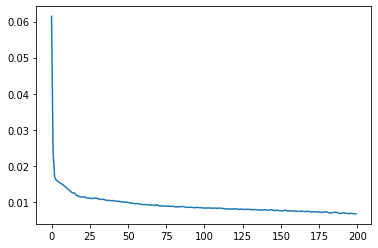

In [18]:
# train model
model, result = train_lstm(train_x, train_y)
plt.plot(result.history['loss'])

In [19]:
# predict purchase
scaled_pred = model.predict(test_x)
pred = inverse_trans_func(scaled_pred)
df_out['purchase'] = pred

In [20]:
# redeem
train_x, train_y, test_x, inverse_trans_func = create_train_test_data(
    df, 'total_redeem_amt', use_other_features=use_other_features)
train_x.shape, train_y.shape, test_x.shape

((367, 1, 30), (367, 30), (1, 1, 30))

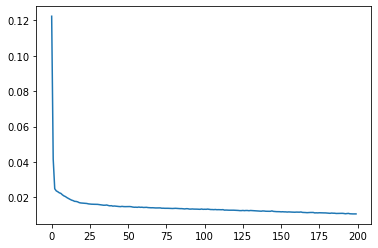

In [21]:
# train model
model, result = train_lstm(train_x, train_y)
plt.plot(result.history['loss'])

In [22]:
# predict redeem
scaled_pred = model.predict(test_x)
pred = inverse_trans_func(scaled_pred)
df_out['redeem'] = pred

In [23]:
# output
print(df_out.to_csv(header=False, index=False))

20140901,317593932.5065153,365120298.3210602
20140902,315421204.683568,312271758.4000168
20140903,292161834.0475526,339816352.6950836
20140904,254039598.02729166,334576962.1767731
20140905,229423892.8599147,282546686.7239685
20140906,189993911.95845014,191755531.0973854
20140907,200962252.20881352,176952727.459692
20140908,257413457.5031013,347626683.466671
20140909,293233590.1330673,314760215.2010536
20140910,300191920.47339195,334231123.63274
20140911,293460173.11974126,312807705.6894531
20140912,227333652.15429276,323626796.0166054
20140913,172466573.49549234,249937572.68384364
20140914,238777344.2772949,236835437.32324985
20140915,324293089.9269872,396113715.7004013
20140916,338322142.29263717,334635377.11376953
20140917,292333978.62988293,296154992.7176399
20140918,262835983.72749668,266052598.27761844
20140919,216739449.39824438,271036033.14632225
20140920,194664423.36581796,202902067.0694218
20140921,223073734.53836364,195180090.5162926
20140922,268668738.1961942,318561674.55866

### score = 102.5355

## predict with feature 1 ~ feature 6

In [24]:
use_other_features = True
# initialize df_out
df_out = pd.DataFrame()
df_out['date'] = ['201409%02d' % k for k in range(1, 31)]

In [25]:
# purchase
train_x, train_y, test_x, inverse_trans_func = create_train_test_data(
    df, 'total_purchase_amt', use_other_features=use_other_features)
train_x.shape, train_y.shape, test_x.shape

((367, 1, 210), (367, 30), (1, 1, 210))

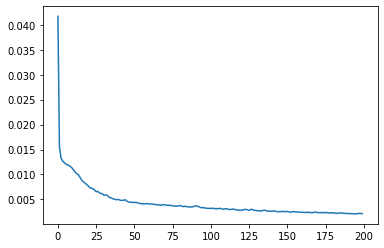

In [26]:
# train model
model, result = train_lstm(train_x, train_y)
plt.plot(result.history['loss'])

In [27]:
# predict purchase
scaled_pred = model.predict(test_x)
pred = inverse_trans_func(scaled_pred)
df_out['purchase'] = pred

In [28]:
# redeem
train_x, train_y, test_x, inverse_trans_func = create_train_test_data(
    df, 'total_redeem_amt', use_other_features=use_other_features)
train_x.shape, train_y.shape, test_x.shape

((367, 1, 210), (367, 30), (1, 1, 210))

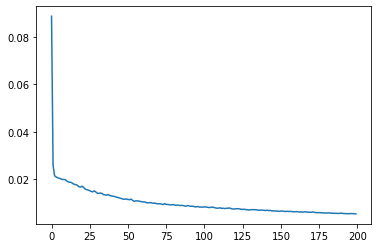

In [29]:
# train model
model, result = train_lstm(train_x, train_y)
plt.plot(result.history['loss'])

In [30]:
# predict redeem
scaled_pred = model.predict(test_x)
pred = inverse_trans_func(scaled_pred)
df_out['redeem'] = pred

In [31]:
# output
print(df_out.to_csv(header=False, index=False))

20140901,263358659.8948205,422026659.8120804
20140902,261619414.73786545,345559198.00725174
20140903,242793723.14321372,349407558.44456863
20140904,238123858.47308758,311330809.55407715
20140905,234674415.09703228,288766023.5879173
20140906,200545373.81852627,235339774.25098804
20140907,233279740.294843,250333320.87198642
20140908,268237280.0989585,391238475.31272125
20140909,298768339.3284004,340069852.7056351
20140910,302832464.2741619,328321294.86481476
20140911,283842515.4796273,307040629.2369385
20140912,234888485.12403014,298465927.9562454
20140913,204478787.54394105,231515775.05410007
20140914,233464889.9195333,255898953.6094189
20140915,292932154.3404209,372341438.34449005
20140916,284478595.61633015,327552338.32780457
20140917,253326921.70596486,334027517.003788
20140918,232549953.55562204,294346406.4221916
20140919,211467978.4982983,275315984.3444824
20140920,203912794.04092956,193358575.52515602
20140921,238432309.95885575,215655940.7719479
20140922,255476226.39315897,311249

### score = 84.4328